In [1]:
# import sys
# sys.path.append('/data/twang15/spatial_protein/code/spatial_basic_func/svg.py')
# from svg import *
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import squidpy as sq
import os
from scipy.sparse import csr_matrix
from tqdm import tqdm
def find_files(directory, substring, extension):
    # 存储符合条件的文件路径
    matching_files = []
    # 遍历给定目录及其所有子目录
    for root, dirs, files in os.walk(directory):
        # 检查每个文件
        for file in files:
            # 检查文件名是否包含特定子字符串并且以特定扩展名结尾
            if substring in file and file.endswith(extension):
                # 如果符合条件，添加完整路径到列表
                matching_files.append(os.path.join(root, file))
    return matching_files

def calculate_neighbor(adata, n_neighbors=1000, x='x', y='y', n_jobs=248):
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean', n_jobs=n_jobs)
    coords = adata.obs[[x, y]]
    nn.fit(coords)
    distances, indices = nn.kneighbors(coords)

    # 获取数据点的总数
    num_points = coords.shape[0]

    # 扁平化索引和距离数组，准备构建稀疏矩阵
    rows = np.repeat(np.arange(num_points), n_neighbors)
    cols = indices.ravel()
    data = distances.ravel()

    # 构建稀疏矩阵
    full_distance_matrix = csr_matrix((data, (rows, cols)), shape=(num_points, num_points))
    connectivities = nn.kneighbors_graph(coords, mode='connectivity')


    adata.obsp['spatial_connectivities'] = connectivities
    adata.obsp['spatial_distances'] = full_distance_matrix
    adata.uns['spatial_neighbors'] = {
        'connectivities_key': 'spatial_connectivities',
        'distances_key': 'distances',
        'params': {'n_neighbors': n_neighbors,
        'method': 'gaussian',
        'random_state': 0,
        'metric': 'euclidean'}
    }
    # results = sc.metrics.morans_i(adata)
    # adata.var['morans'] = results
    # gene_ranks = adata.var['morans'].rank(ascending=False).sort_index() 
    # rnk_threshold = np.percentile(gene_ranks, 10.0)
    # gene_svgs = gene_ranks[gene_ranks<rnk_threshold].sort_values().index
    return adata

In [2]:
save_path = '/data/twang15/spatial_protein/CODEX_data/hubmap/proximity/thymus/'
files = find_files('/data/twang15/spatial_protein/CODEX_data/hubmap/integrated/thymus', 'integrated', '.h5ad')

In [18]:
files[3]

'/data/twang15/spatial_protein/CODEX_data/hubmap/integrated/thymus/HBM597.KZXW.469_reg1_protein_integrated.h5ad'

In [14]:
for file in tqdm(files[2:]):
    tmp = sc.read_h5ad(file)
    tissue = file.split('/')[8].replace('_protein_integrated.h5ad', '')
    print(tissue)
    calculate_neighbor(tmp, n_neighbors=1000, x='x', y='y', n_jobs=248)
    sq.gr.nhood_enrichment(tmp, cluster_key="cell_type")
    sq.pl.nhood_enrichment(tmp, cluster_key="cell_type", method=None, figsize=(5, 5), title='Cell Type spatial community')
    os.makedirs(f'{save_path}/{tissue}/', exist_ok=True)
    plt.savefig(f'{save_path}/{tissue}/proximity_celltype.png')
    plt.close()
    sq.gr.nhood_enrichment(tmp, cluster_key="neighborhood10")
    sq.pl.nhood_enrichment(tmp, cluster_key="neighborhood10", method=None, figsize=(5, 5), title='Cell Type spatial community')
    plt.savefig(f'{save_path}/{tissue}/proximity_neighborhood.png')
    plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]/data/twang15/mamba/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

 10%|█         | 1/10 [01:03<09:30, 63.40s/it]


KeyboardInterrupt: 

In [13]:
for file in tqdm(files[2:]):
    tmp = sc.read_h5ad(file)
    tissue = file.split('/')[8].replace('_protein_integrated.h5ad', '')
    calculate_neighbor(tmp, n_neighbors=1000, x='x', y='y', n_jobs=248)
    sq.gr.nhood_enrichment(tmp, cluster_key="neighborhood10")
    sq.pl.nhood_enrichment(tmp, cluster_key="neighborhood10", method=None, figsize=(5, 5), title='Cell Type spatial community')
    plt.savefig(f'{save_path}/{tissue}/proximity_neighborhood.png')
    plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]/data/twang15/mamba/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
  0%|          | 0/10 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [3]:
tmp = sc.read_h5ad(files[0])
tissue = files[0].split('/')[8].replace('_protein_integrated.h5ad', '')
calculate_neighbor(tmp, n_neighbors=1000, x='x', y='y', n_jobs=248)
sq.gr.nhood_enrichment(tmp, cluster_key="cell_type")
sq.pl.nhood_enrichment(tmp, cluster_key="cell_type", method=None, figsize=(5, 5), title='Cell Type spatial community')
os.makedirs(f'{save_path}/{tissue}/', exist_ok=True)
plt.savefig(f'{save_path}/{tissue}/proximity_celltype.png')
plt.close()

/data/twang15/mamba/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/1000 [00:00<?, ?/s]

/data/twang15/mamba/envs/mip/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


In [4]:
files[0]

'/data/twang15/spatial_protein/CODEX_data/hubmap/integrated/thymus/HBM857.ZBDC.975_reg1_protein_integrated.h5ad'

In [12]:
tissue

'HBM785.CNWZ.888_reg1'

In [11]:
tmp = sc.read_h5ad(files[1])
tissue = files[1].split('/')[8].replace('_protein_integrated.h5ad', '')
print(tissue)
calculate_neighbor(tmp, n_neighbors=1000, x='x', y='y', n_jobs=248)
sq.gr.nhood_enrichment(tmp, cluster_key="cell_type")
sq.pl.nhood_enrichment(tmp, cluster_key="cell_type", method=None, figsize=(5, 5), title='Cell Type spatial community')
os.makedirs(f'{save_path}/{tissue}/', exist_ok=True)
plt.savefig(f'{save_path}/{tissue}/proximity_celltype.png', bbox_inches='tight')
plt.close()
sq.gr.nhood_enrichment(tmp, cluster_key="neighborhood10")
sq.pl.nhood_enrichment(tmp, cluster_key="neighborhood10", method=None, figsize=(5, 5), title='Cell Type spatial community')
plt.savefig(f'{save_path}/{tissue}/proximity_neighborhood.png', bbox_inches='tight')
plt.close()

/data/twang15/mamba/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


  0%|          | 0/1000 [00:00<?, ?/s]

/data/twang15/mamba/envs/mip/lib/python3.8/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in true_divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


  0%|          | 0/1000 [00:00<?, ?/s]

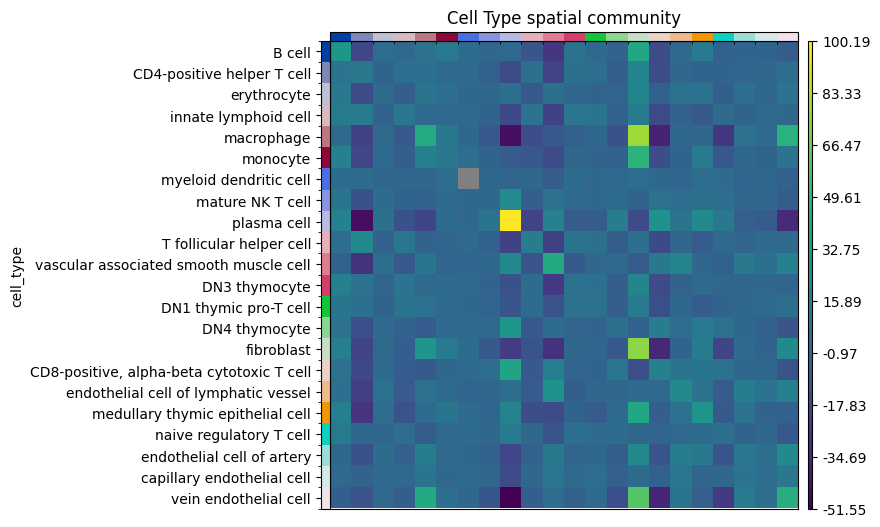

In [8]:
sq.pl.nhood_enrichment(tmp, cluster_key="cell_type", method=None, figsize=(5, 5), title='Cell Type spatial community')
plt.savefig(f'{save_path}/{tissue}/proximity_celltype.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>